In [1]:
# libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tclab
import time
from torchmetrics import R2Score, MeanSquaredError

import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

r2score = R2Score()
msescore = MeanSquaredError()

torch.manual_seed(0)

In [2]:
# Model (system)
class System(torch.nn.Module):
    def __init__(self):
        super(System, self).__init__()
        self.input_ini    = torch.nn.Linear(1, 12)
        self.input_signal = torch.nn.Linear(10,12)
        self.input_t      = torch.nn.Linear(1, 12)

    def forward(self, x_0, u, t):
        z_ini   = torch.selu(self.input_ini(x_0))
        z_input = torch.selu(self.input_signal(u))
        z_t     = torch.selu(self.input_t(t))
        z       = z_ini * z_input * z_t
        z       = torch.sum(z).reshape(-1,1)
        return z

In [3]:
class MPC(torch.nn.Module):
    def __init__(self, T):
        super(MPC, self).__init__()
        self.u = torch.nn.Parameter(torch.ones(T))

    def forward(self, system, umin, umax, y0, yT, R, Q, P, U):
        u = self.u
        lu = torch.relu(umin-u).sum() + torch.relu(u-umax).sum()
        l1 = ((u[1:] - u[0:-1]).sum().expand(1))**2
        l2 = 0
        for i in range(10):
            y1 = system(y0, u, torch.tensor([i*1.0]))
            l2 = l2 + (y1-yT)**2
        loss = P*torch.sum(u**2) + R*l1 + Q*l2 + U*lu
        return loss

In [4]:
# Train function
loss_function = torch.nn.MSELoss()
def train(system, mpc, umin, umax, y0, yT, R, Q, P, U, epochs, _lr):
    opt = torch.optim.Adam(mpc.parameters(), lr=_lr)
    for epoch in range(epochs+1):
        opt.zero_grad()
        loss = loss_function(mpc(system, umin, umax, y0, yT, R, Q, P, U), torch.tensor([[0.]]))
        loss.backward(retain_graph=True)
        opt.step()

In [5]:
# parameter for MPC
N  = 120                            # prediction horizon length
T  = 10                             # control horizon length
y0 = torch.tensor([20.])            # y0 (just for testing, don't need it in implementing the real board)
yT = torch.tensor([32.])            # yT
umin = 0                            # u min
umax = 100                          # u max
R = 1e1                             # input change penalty
Q = 1e2                             # reference difference penalty
P = 1e1                             # input penalty
U = 1e9                             # input violation penalty

In [6]:
# plant
system = torch.load('system.pt')

# model
mpc = MPC(T)

# Train MPC
lab = tclab.TCLab()

u_vector = np.zeros(N+1)
y_vector = np.zeros(N+1)
y_vector[0] = lab.T1

y0 = torch.tensor([lab.T1])
for i in range(N):
    st = time.time()
    train(system, mpc, umin, umax, y0, yT, R, Q, P, U, epochs=100, _lr=0.01)
    u = mpc.u
    et = time.time()
    time.sleep(10 - (et-st))
    lab.Q1(u.detach().numpy()[0])
    
    y0 = lab.T1
    u_vector[1+i] = u.detach().numpy()[0]
    y_vector[1+i] = y0
    
    print("i = %3d \t u = %5.3f \t y = %5.3f" % (i, u.detach().numpy()[0], y0))
    y0 = torch.tensor([y0*1.0])

lab.close()

TCLab version 0.4.9
Arduino Leonardo connected on port COM4 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.


c:\Users\tln229\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


i =     0 	 u = 0.525 	 y = 20.254
i =     1 	 u = 1.224 	 y = 20.254
i =     2 	 u = 2.050 	 y = 20.254
i =     3 	 u = 2.769 	 y = 20.254
i =     4 	 u = 3.695 	 y = 20.318
i =     5 	 u = 4.586 	 y = 20.351
i =     6 	 u = 5.356 	 y = 20.576
i =     7 	 u = 5.953 	 y = 20.576
i =     8 	 u = 6.409 	 y = 20.641
i =     9 	 u = 7.439 	 y = 20.898
i =    10 	 u = 8.477 	 y = 20.995
i =    11 	 u = 9.519 	 y = 21.221
i =    12 	 u = 10.545 	 y = 21.479
i =    13 	 u = 11.562 	 y = 21.543
i =    14 	 u = 12.577 	 y = 21.865
i =    15 	 u = 13.585 	 y = 22.188
i =    16 	 u = 14.587 	 y = 22.510
i =    17 	 u = 15.584 	 y = 22.832
i =    18 	 u = 16.577 	 y = 23.154
i =    19 	 u = 17.559 	 y = 23.477
i =    20 	 u = 18.532 	 y = 23.799
i =    21 	 u = 19.494 	 y = 24.153
i =    22 	 u = 20.444 	 y = 24.733
i =    23 	 u = 21.333 	 y = 25.088
i =    24 	 u = 22.200 	 y = 25.410
i =    25 	 u = 23.017 	 y = 26.022
i =    26 	 u = 23.425 	 y = 26.377
i =    27 	 u = 22.859 	 y = 26.731
i = 

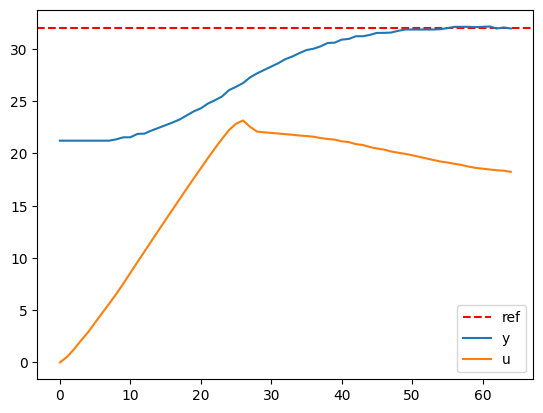

In [ ]:
# Plot
a = 0
b = 65
plt.axhline(y = yT.detach().numpy()[0], color = 'r', linestyle = '--', label='ref')
plt.plot(y_vector[a:b], label='y')
plt.plot(u_vector[a:b], label='u')
plt.legend()
plt.show()